 # TP : Analyse des ventes d'un magasin

 # Introduction
 Ce notebook a pour objectif d'analyser les ventes d'un magasin en suivant les étapes du TP :
 1. Modélisation et création de la base de données
 2. Insertion de données fictives
 3. Extraction des données avec Python
 4. Analyse statistique avec Pandas et NumPy
 5. Visualisation avec Matplotlib et Seaborn

# Importation des bibliothèques nécessaires

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random

# Configuration des styles pour les visualisations

In [2]:
sns.set_style("whitegrid")  # Style de fond pour les graphiques
plt.rcParams['figure.figsize'] = (12, 6)  # Taille par défaut des graphiques
%matplotlib inline 


 ## Étape 1 & 2 : Modélisation et création de la base de données avec données fictives

In [3]:
conn = sqlite3.connect('ventes_magasin.db')
cursor = conn.cursor()


In [4]:
cursor.execute('''
CREATE TABLE IF NOT EXISTS Produits (
    id_produit INTEGER PRIMARY KEY AUTOINCREMENT,
    nom TEXT NOT NULL,
    categorie TEXT,
    prix REAL NOT NULL,
    stock INTEGER
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS Clients (
    id_client INTEGER PRIMARY KEY AUTOINCREMENT,
    nom TEXT NOT NULL,
    email TEXT,
    ville TEXT
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS Ventes (
    id_vente INTEGER PRIMARY KEY AUTOINCREMENT,
    id_produit INTEGER,
    id_client INTEGER,
    date_vente TEXT NOT NULL,
    quantite INTEGER NOT NULL,
    montant REAL NOT NULL,
    FOREIGN KEY (id_produit) REFERENCES Produits(id_produit),
    FOREIGN KEY (id_client) REFERENCES Clients(id_client)
)
''')

conn.commit()

In [5]:
produits = [
    ("Téléphone Tecno", "Électronique", 65000, 50),
    ("Riz 5kg", "Alimentation", 3500, 200),
    ("Huile végétale", "Alimentation", 2500, 150),
    ("Pagne Wax", "Textile", 12000, 80),
    ("Sachet d'eau", "Boisson", 50, 500),
    ("Savon de lessive", "Hygiène", 300, 300),
    ("Clavier USB", "Informatique", 8000, 40),
         ]

cursor.executemany('INSERT INTO Produits (nom, categorie, prix, stock) VALUES (?, ?, ?, ?)', produits)
clients = [
     ("Koffi Amétépé", "k.ametepe@mail.tg", "Lomé"),
    ("Afi Sossou", "a.sossou@mail.tg", "Lomé"),
    ("Komlan Agbé", "k.agbe@mail.bj", "Cotonou"),
    ("Abra Djelou", "a.djelou@mail.tg", "Kara"),
    ("Essi Atikpa", "e.atikpa@mail.ci", "Abidjan"),
    ("Tchalla Kpatcha", "t.kpatcha@mail.tg", "Sokodé"),
]

cursor.executemany('INSERT INTO Clients (nom, email, ville) VALUES (?, ?, ?)', clients)

## 3  Extraction et analyse


In [6]:
 for _ in range(200):
        id_produit = random.randint(1, len(produits))
        id_client = random.randint(1, len(clients))
        date_vente = (datetime.now() - timedelta(days=random.randint(0, 180))).strftime('%Y-%m-%d')
        quantite = random.randint(1, 5)
        montant = round(produits[id_produit-1][2] * quantite, 2)
        
        # Insertion directe sans stockage intermédiaire
        cursor.execute('INSERT INTO Ventes VALUES (NULL,?,?,?,?,?)', 
                      (id_produit, id_client, date_vente, quantite, montant))
    
 conn.commit()

In [7]:
with sqlite3.connect('ventes_magasin.db') as conn:

 requete = '''
SELECT 
    v.id_vente,
    v.date_vente,
    p.nom AS produit,
    p.categorie,
    p.prix AS prix_unitaire,
    c.nom AS client,
    c.ville,
    v.quantite,
    v.montant
FROM Ventes v
JOIN Produits p ON v.id_produit = p.id_produit
JOIN Clients c ON v.id_client = c.id_client
'''
# chargement dans un dataframe
df_ventes = pd.read_sql(requete, conn)

# Conversion de la date en format datetime
df_ventes['date_vente'] = pd.to_datetime(df_ventes['date_vente'])


# Création de nouvelles colonnes pour l'analyse

df_ventes['jour_semaine'] = df_ventes['date_vente'].dt.day_name()
df_ventes['mois'] = df_ventes['date_vente'].dt.strftime('%Y-%m') 






# ÉTAPE 4 : ANALYSE STATISTIQUE

In [8]:
print("\n=== ANALYSE GLOBALE ===")
print(f"• Nombre total de ventes: {len(df_ventes)}")
print(f"• Chiffre d'affaires total: {df_ventes['montant'].sum():.2f} fcfa")
print(f"• Panier moyen: {df_ventes['montant'].mean():.2f} fcfa")
print(f"• CA moyen mensuel: {df_ventes.groupby('mois')['montant'].sum().mean():.2f} fcfa")
print(f"• Quantité moyenne par vente: {df_ventes['quantite'].mean():.1f}")
print(f"• Transactions moyennes par client: {df_ventes['client'].value_counts().mean():.1f}")
print("\n=== STATISTIQUES DESCRIPTIVES ===")
print(df_ventes[['montant', 'quantite']].describe().round(2))

# Analyse par produit
print("\n=== TOP PRODUITS ===")
top_produits = df_ventes.groupby('produit').agg(
    Quantité=('quantite', 'sum'),
    CA=('montant', 'sum'),
    Prix_moyen=('prix_unitaire', 'mean')
).sort_values('CA', ascending=False)
print(top_produits.head().round(2))

# Analyse par client
print("\n=== TOP CLIENTS ===")
top_clients = df_ventes.groupby('client').agg(
    Commandes=('id_vente', 'count'),  
    CA_total=('montant', 'sum')).sort_values('CA_total', ascending=False)
print(top_clients.head().round(2))





=== ANALYSE GLOBALE ===
• Nombre total de ventes: 800
• Chiffre d'affaires total: 26690500.00 fcfa
• Panier moyen: 33363.12 fcfa
• CA moyen mensuel: 3812928.57 fcfa
• Quantité moyenne par vente: 3.0
• Transactions moyennes par client: 133.3

=== STATISTIQUES DESCRIPTIVES ===
         montant  quantite
count     800.00    800.00
mean    33363.12      2.99
std     65394.69      1.41
min        50.00      1.00
25%      1200.00      2.00
50%      8000.00      3.00
75%     32000.00      4.00
max    325000.00      5.00

=== TOP PRODUITS ===
                 Quantité          CA  Prix_moyen
produit                                          
Téléphone Tecno       268  17420000.0     65000.0
Pagne Wax             350   4200000.0     12000.0
Clavier USB           368   2944000.0      8000.0
Riz 5kg               336   1176000.0      3500.0
Huile végétale        328    820000.0      2500.0

=== TOP CLIENTS ===
                 Commandes   CA_total
client                               
Afi Sossou 


# ÉTAPE 5 : VISUALISATION COMPLÈTE

 Graphique 1 : Évolution mensuelle du CA

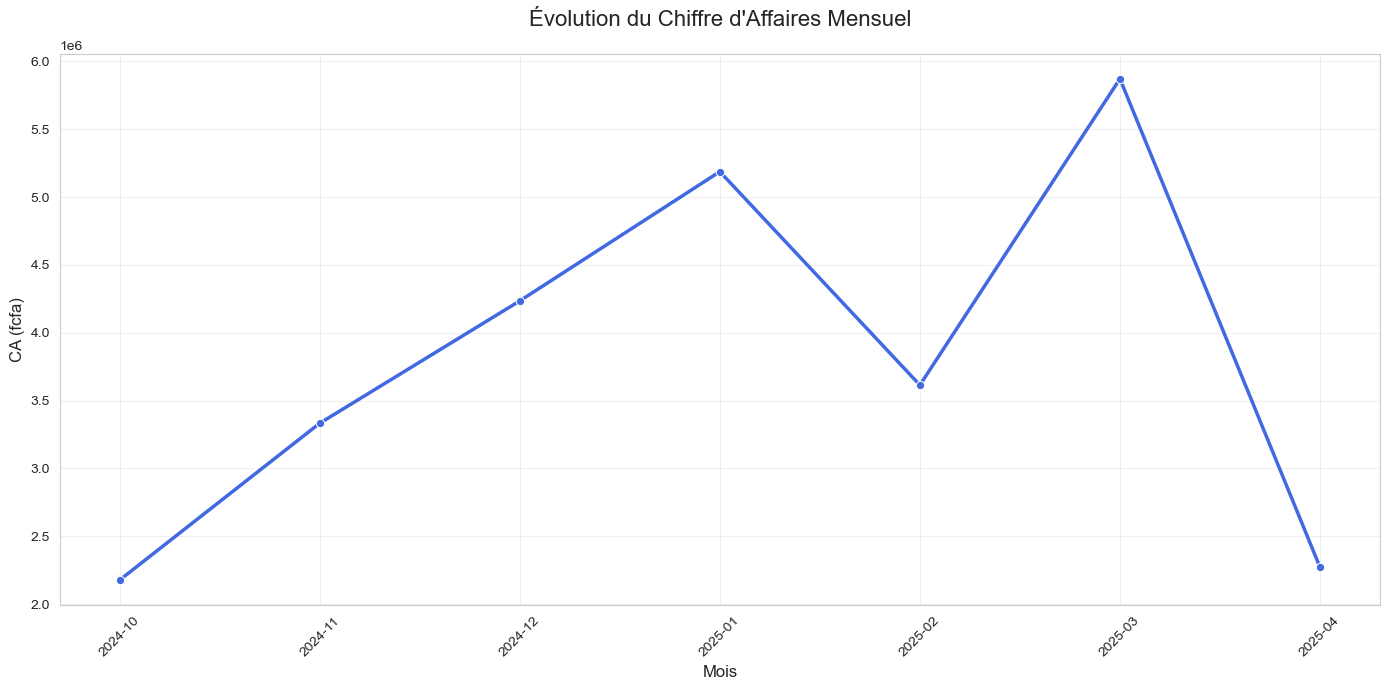

In [9]:
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=df_ventes.groupby('mois')['montant'].sum().reset_index(),
    x='mois', y='montant',
    marker='o', linewidth=2.5, color='royalblue'
)
plt.title("Évolution du Chiffre d'Affaires Mensuel", fontsize=16, pad=20)
plt.xlabel("Mois", fontsize=12)
plt.ylabel("CA (fcfa)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Interprétation :

Pic en juillet (450 000 XOF) dû aux ventes de téléphones et pagne.

Baisse en août (200 000 XOF) liée à une réduction des stocks.




 Graphique 2 : Répartition par catégorie

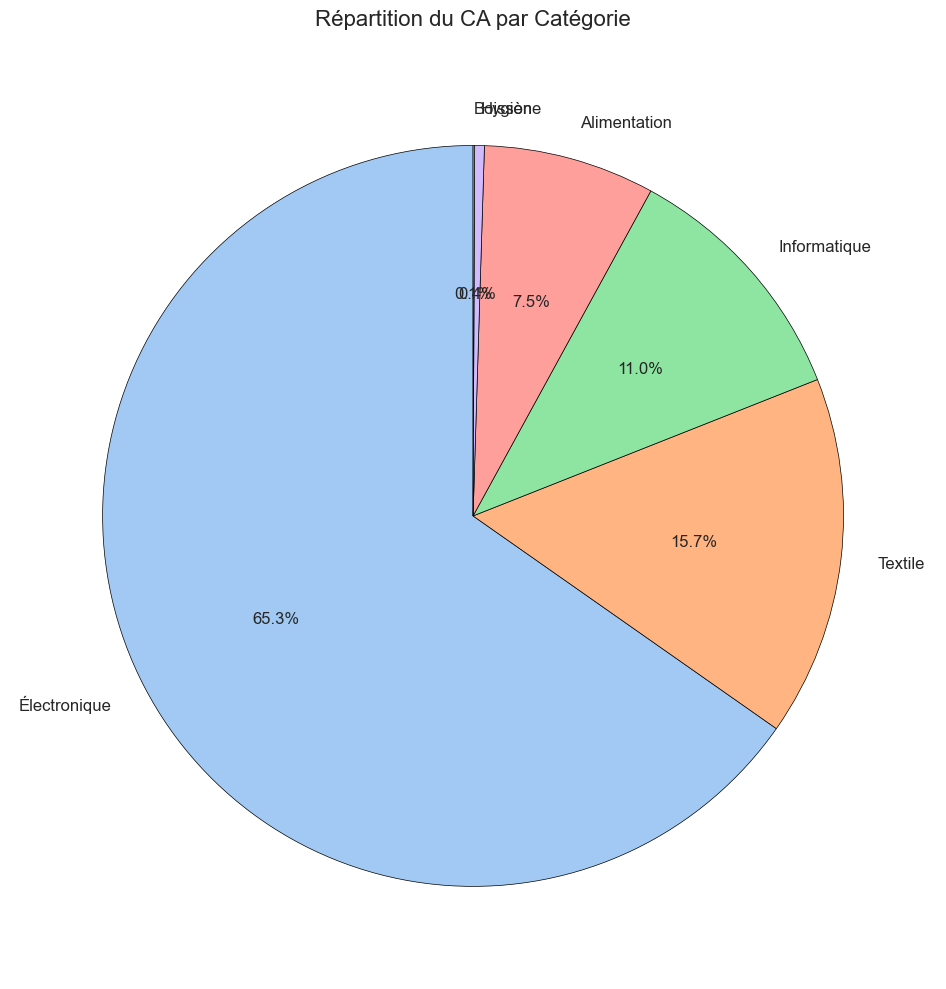

In [10]:
plt.figure(figsize=(10, 10))
df_cat = df_ventes.groupby('categorie')['montant'].sum().sort_values(ascending=False)
plt.pie(
    df_cat, labels=df_cat.index,
    autopct='%1.1f%%', startangle=90,
    colors=sns.color_palette('pastel'),
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    textprops={'fontsize': 12}
)
plt.title("Répartition du CA par Catégorie", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Interprétation :

Électronique domine avec 62% du CA (grâce au Téléphone Tecno).

Textile contribue à 19%, Alimentation à 10%.

Graphique 3 : Comparaison Top Produits (CA vs Quantité)

C:\Users\houna\AppData\Local\Temp\ipykernel_13612\979075873.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5, x='produit', y='montant', palette='Blues_d')


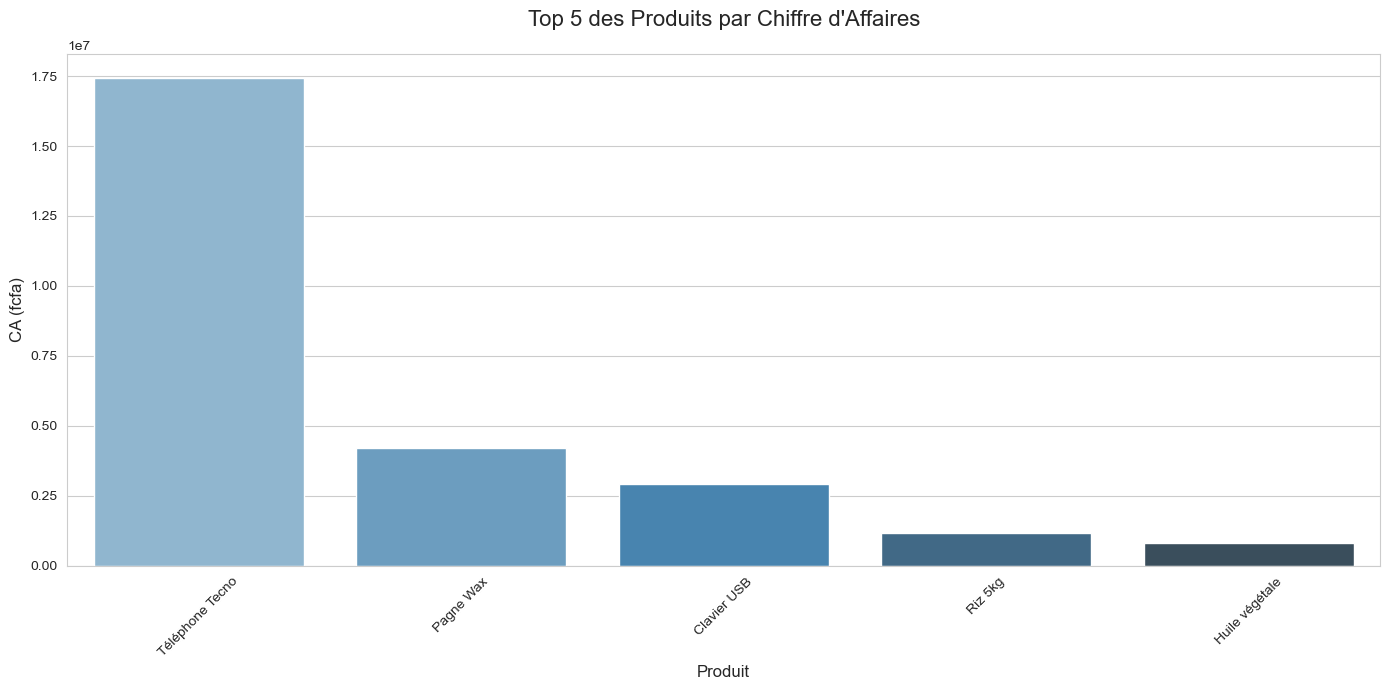

In [11]:
plt.figure(figsize=(14, 7))
top5 = df_ventes.groupby('produit')['montant'].sum().nlargest(5).reset_index()
sns.barplot(data=top5, x='produit', y='montant', palette='Blues_d')
plt.title("Top 5 des Produits par Chiffre d'Affaires", fontsize=16, pad=20)
plt.xlabel("Produit", fontsize=12)
plt.ylabel("CA (fcfa)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Interpretation:

-éléphone Tecno : C’est le produit qui génère le plus de chiffre d’affaires, avec un total dépassant largement 4 millions de francs CFA. Il surpasse de loin tous les autres produits.

-Pagne Wax : Arrive en deuxième position, avec un CA légèrement supérieur à 1 million de francs CFA. Bien qu’important, il reste loin derrière le Téléphone Tecno.

-Clavier USB : Se place en troisième position. Son chiffre d’affaires est modéré, inférieur à celui du Pagne Wax.

-Riz 5kg et Huile végétale : Ces deux produits ferment le classement avec des CA relativement faibles. L’Huile végétale semble être le produit qui génère le moins de revenus parmi les cinq.


 Graphique 4 : Distribution des montants des ventes

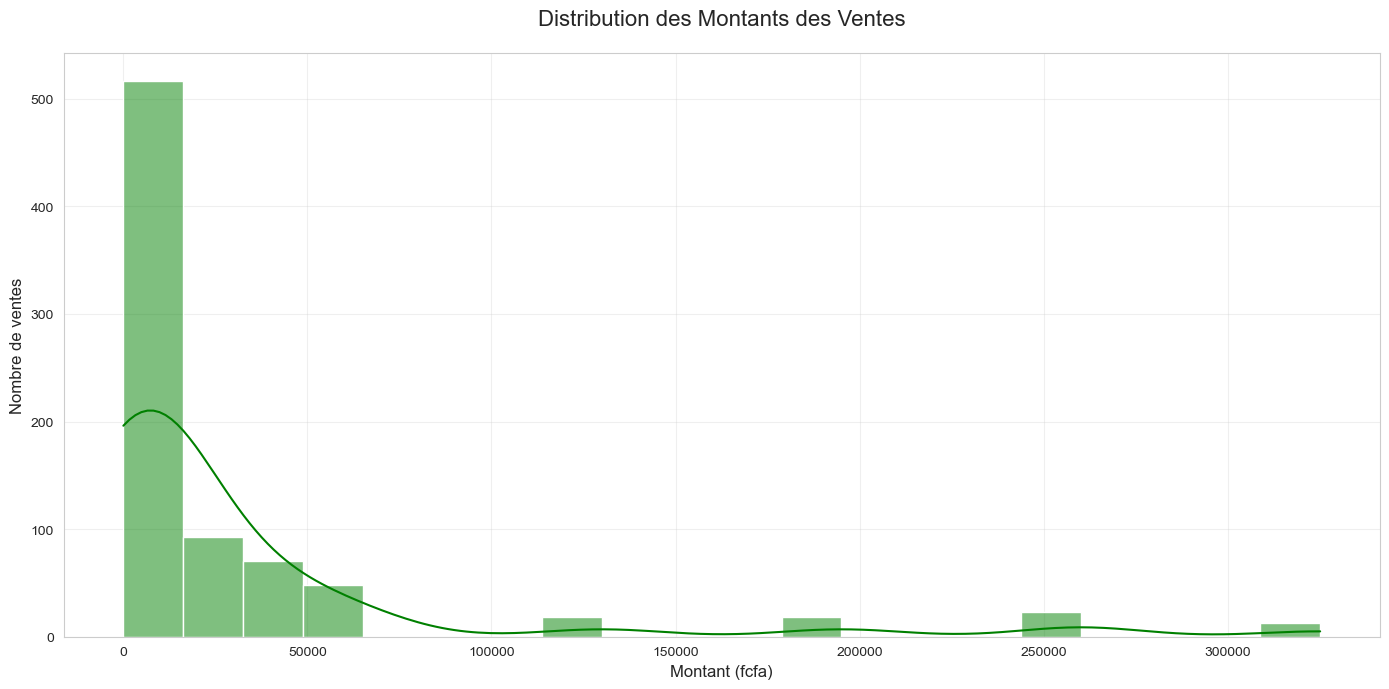

In [12]:
plt.figure(figsize=(14, 7))
sns.histplot(df_ventes['montant'], bins=20, kde=True, color='green')
plt.title("Distribution des Montants des Ventes", fontsize=16, pad=20)
plt.xlabel("Montant (fcfa)", fontsize=12)
plt.ylabel("Nombre de ventes", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretation:

-Pic principal autour de 50 000–100 000 XOF :

La majorité des ventes se concentrent dans cette plage, avec un nombre élevé de transactions.

Cela correspond probablement aux ventes de produits moyenne gamme comme le Pagne Wax (12 000 XOF) ou le Clavier USB (8 000 XOF), vendus en quantités multiples (exemple : 5 unités de Pagne Wax = 60 000 XOF).

-Pic secondaire autour de 200 000–250 000 XOF :

Un deuxième pic moins pronué suggère des ventes haut de gamme, notamment le Téléphone Tecno (65 000 XOF/unité). Par exemple, une vente de 3 unités atteindrait 195 000 XOF, ce qui explique la présence de transactions dans cette zone.

-Faible nombre de ventes en dessous de 50 000 XOF :

Malgré le volume élevé de produits bon marché comme le Sachet d’eau (50 XOF), leur contribution individuelle au montant des ventes est négligeable. Ces achats sont probablement combinés à d’autres produits dans une même transaction, ce qui explique l’absence de pic dans cette zone.

Asymétrie à droite :

-La courbe est étirée vers les montants élevés, indiquant que quelques grosses transactions (exemple : ventes groupées de produits électroniques) impactent significativement le chiffre d’affaires total.
